This notebook is to develop algorithm to reconstruct voltage measurement

In [1]:
# import used functioons 
#  import tools 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.utils import plot_model
import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

Import the path of test files

In [53]:
# 開啟互動模式
%matplotlib widget


# Data set folder 
NTU_dataset_path = r'D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data'

# 只引入 15kg_1V_1800rpm_1的資料

# -----------------------10psi data--------------------

collect_setting = r"Load_1V\Speed_1800\Pressure_10psi"
test_files_path=(os.path.join(NTU_dataset_path, collect_setting, r"15kg_1V_1800rpm_1"))

# 確認 train_file_list 中的所有路徑是否存在
print(os.path.exists(test_files_path))

# 取出 rul2_dataset_path 中的所有 file 名稱並按照順序排列
rul2_files = [f for f in os.listdir(test_files_path) if os.path.isfile(os.path.join(test_files_path, f))]
rul2_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))
# 將每一個 rul2_files 檔案都與 test_files_path 路徑合併，得到完整路徑列表
rul2_files = [os.path.join(test_files_path, f) for f in rul2_files]



# # Data set folder 
# NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
# Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')

# # 列出此資料夾的所有子資料夾
# Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

# selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V", "3000_0_1V", "3000_0_2V" ]  # 選擇特定資料夾
# # 選擇與 selected_folder 名稱符合的特定資料夾
# Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# # 分割內部測試與訓練集
# train_files = []
# val_files = []
# for folder in Normal_subfolders:
#     parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
#     # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
#     if len(parquet_files) > 1:
#         train, val = train_test_split(parquet_files, test_size=0.2)
       
#         train_files.extend(train)
#         val_files.extend(val)
#     elif len(parquet_files) == 1:
#         train_files.extend(parquet_files)

# rul2_files= train_files + val_files



True


檢視單筆採樣狀況

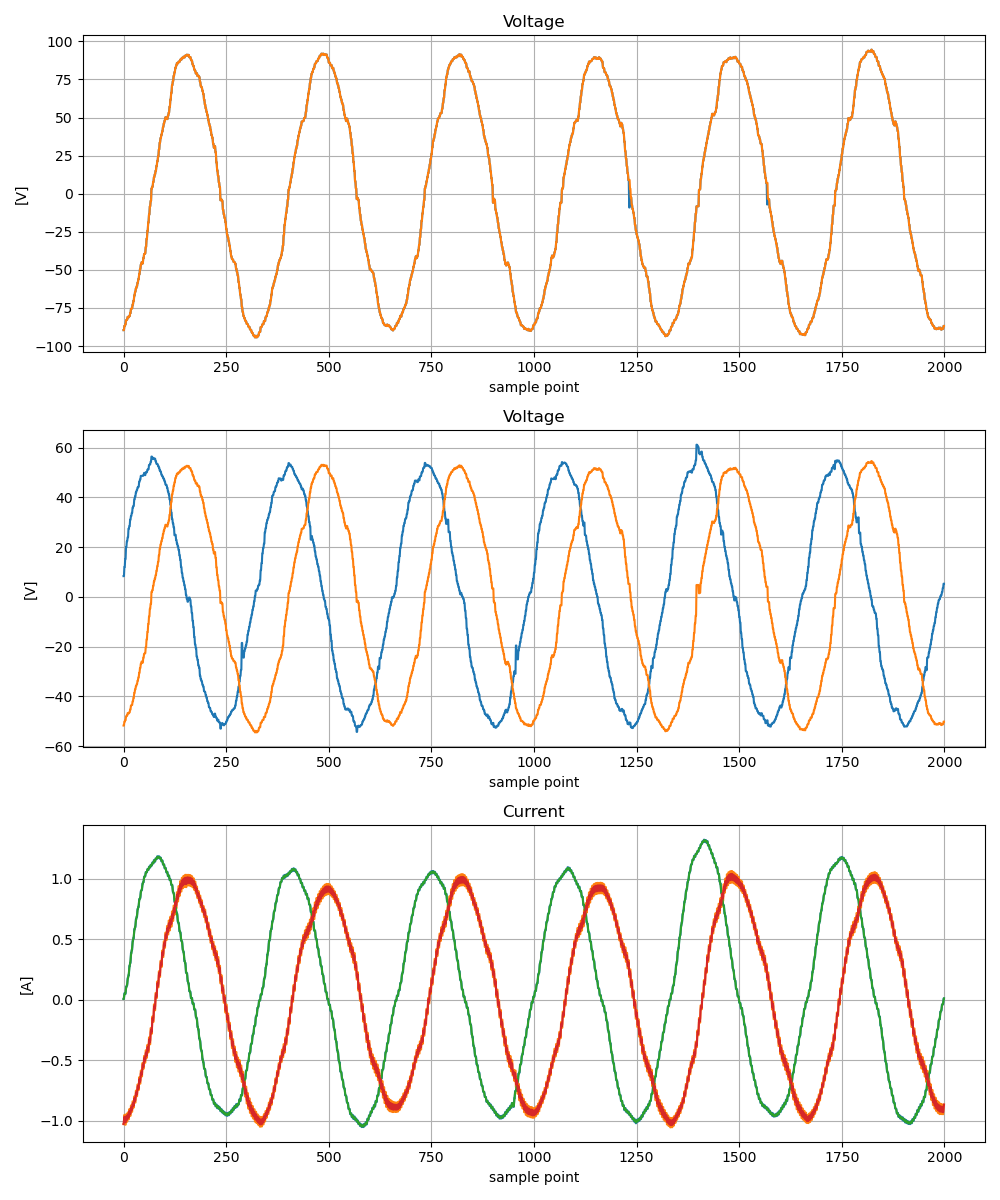

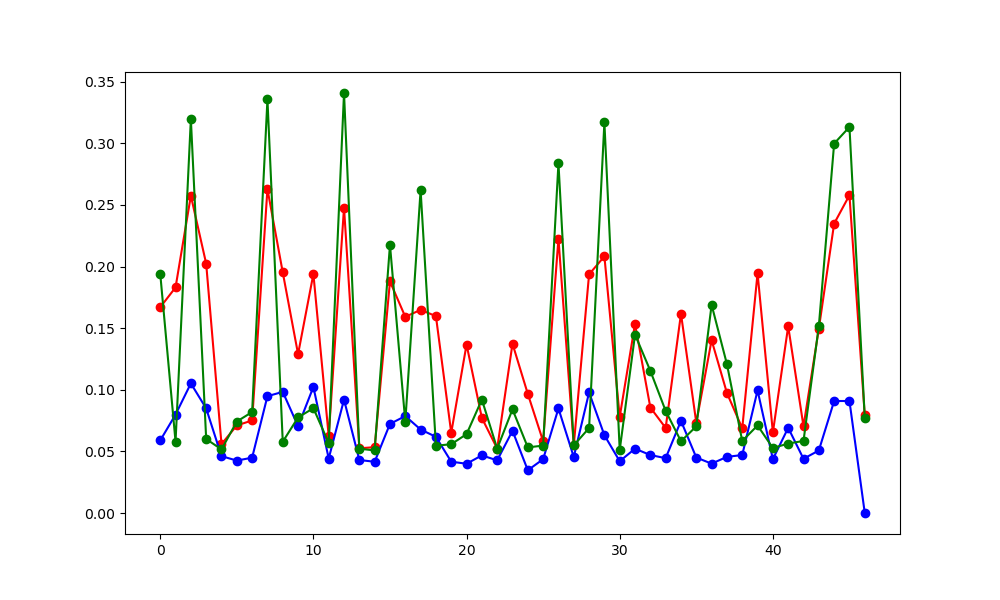

In [54]:
import math
def calculate_thd(signal):
    """
    Calculate Total Harmonic Distortion (THD) of a 1D numpy array.
    """
    signal = np.squeeze(signal)
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N)
    fft_mags = np.abs(fft_vals)[:N // 2]
    # Find the index of the fundamental frequency (ignore DC)
    fundamental_idx = np.argmax(fft_mags[1:]) + 1
    fundamental_mag = fft_mags[fundamental_idx]
    # Harmonics: 2nd, 3rd, ..., up to Nyquist
    harmonics_mag = np.sqrt(np.sum(fft_mags[fundamental_idx*2:]**2))
    thd = harmonics_mag / fundamental_mag
    return thd

def filter_top_n_frequencies(signal, n):
    """
    保留頻譜中前 n 個最大振幅的頻率分量，其餘設為 0，並還原時域訊號。

    Parameters:
    signal : 1D numpy array
        輸入的時域訊號。
    n : int
        要保留的最大頻率分量個數（不含DC）。

    Returns:
    filtered_signal : 1D numpy array
        經過濾波處理後的時域訊號。
    filtered_fft : 1D numpy array (complex)
        經過濾波的頻域資訊。
    """
    signal = np.squeeze(signal)
    N = len(signal)

    # FFT 及頻率
    fft_vals = np.fft.fft(signal)
    fft_mags = np.abs(fft_vals)

    # 忽略 DC 分量（index 0）來尋找最大值
    indices = np.argsort(fft_mags[1:N//2])[-n:] + 1  # +1 是因為跳過 DC

    # 建立遮罩，只保留前 n 個
    mask = np.zeros_like(fft_vals, dtype=bool)
    mask[indices] = True
    mask[-indices] = True  # 同步保留負頻率分量

    # DC 也可以選擇保留
    mask[0] = True

    # 應用遮罩
    filtered_fft = np.zeros_like(fft_vals, dtype=complex)
    filtered_fft[mask] = fft_vals[mask]

    # IFFT 還原時域訊號
    filtered_signal = np.fft.ifft(filtered_fft).real

    return filtered_signal, filtered_fft

 
def voltage_calibrate(raw_voltage, threshold, speed=1):
   
    check_length=int (20000/(speed/3000*200)/4) # 取1/4 週期作為檢測窗長度
    calib_signal = np.copy(raw_voltage)
    
    # 從尾端往前掃描
    for i in range(len(raw_voltage) - 1, 0, -1):
        #檢查訊號差突變點
        if raw_voltage[i]- raw_voltage[i - 1] > threshold and  raw_voltage[i]*raw_voltage[i - 1]<0:
            closest_idx = None
            closest_val = float('inf') 
            for idx in range(max(i-check_length,0), i):
                if (abs(raw_voltage[idx]))<closest_val:
                    closest_val = abs(raw_voltage[idx])
                    closest_idx = idx
            # print(f"Calibrate from {max(i-check_length,0)} to {closest_idx}")
            calib_signal[closest_idx:i]= abs(raw_voltage[closest_idx:i])

    # 第二遍 從頭掃描
    for i in range(len(raw_voltage)):
        #檢查訊號差突變點
        if raw_voltage[i]- raw_voltage[i - 1] < -threshold and  raw_voltage[i]*raw_voltage[i - 1]<0:
            closest_idx = None
            closest_val = float('inf') 
            for idx in range(i, min(i+check_length,len(raw_voltage))):
                if (abs(raw_voltage[idx]))<closest_val:
                    closest_val = abs(raw_voltage[idx])
                    closest_idx = idx
            # print(f"Calibrate from {closest_idx} to {min(i+check_length,len(raw_voltage))}")
            calib_signal[i:closest_idx]= abs(raw_voltage[i:closest_idx])
            
    return calib_signal

def voltage_calibrate_v2(raw_voltage, threshold, speed=1):
   
    calib_signal = np.copy(raw_voltage)
    # 從尾端往前掃描
    for i in range(len(raw_voltage)):
        #檢查訊號差突變點
        one_step_diff=abs(raw_voltage[i]- raw_voltage[i - 1])
        one_step_diff_invert= abs(raw_voltage[i]*-1-raw_voltage[i - 1])
        if one_step_diff > threshold and one_step_diff_invert < one_step_diff:
           calib_signal[i]=raw_voltage[i]*-1
    return calib_signal


def voltage_calibrate_stator(v_alpha, v_beta, threshold, speed=1 ):
    #轉換回 vsensing 線間電壓
    v_ab=(3*v_alpha-math.sqrt(3)*v_beta)/2
    v_bc=math.sqrt(3)*(v_beta)
    # 對 v_ab 和 v_bc 進行校準
    v_ab=voltage_calibrate(v_ab, threshold, speed)
    v_bc=voltage_calibrate(v_bc, threshold, speed)
    # v_ab=voltage_calibrate_v2(v_ab, threshold, speed)
    # v_bc=voltage_calibrate_v2(v_bc, threshold, speed)
    #轉換回 alpha beta 電壓
    v_alpha = (2*v_ab + v_bc)/3
    v_beta = v_bc/math.sqrt(3)
    return v_alpha, v_beta


def plot_electrical_sample(sampled_data):
   
    fig = plt.figure(figsize=(10, 12))
    
    # Subplot for voltage
    v_alpha=sampled_data["Voltage alpha"]
    v_beta=sampled_data["Voltage beta"]
    v_ab=(3*v_alpha-math.sqrt(3)*v_beta)/2
    v_bc=math.sqrt(3)*(v_beta)
    
    v_alpha, v_beta = voltage_calibrate_stator(v_alpha, v_beta, 10, sampled_data["Speed"][0])
    v_ab_calib=voltage_calibrate(v_ab, 12, sampled_data["Speed"][0])
    v_bc_calib=voltage_calibrate(v_bc, 12, sampled_data["Speed"][0])

    plt.subplot(3, 1, 1)
    # plt.plot(v_ab, linestyle='-')
    # plt.plot(v_bc, linestyle='-')
    
    plt.plot(v_bc, linestyle='-')
    plt.plot(v_bc_calib, linestyle='-')
    plt.xlabel("sample point")
    plt.ylabel("[V]")
    plt.title("Voltage")
    plt.grid()

    
    plt.subplot(3, 1, 2)
    plt.plot(v_alpha, linestyle='-')
    plt.plot(v_beta, linestyle='-')
    # plt.plot(sampled_data["Voltage alpha downsample"], linestyle='-')
    # plt.plot(sampled_data["Voltage beta downsample"], linestyle='-')
    plt.xlabel("sample point")
    plt.ylabel("[V]")
    plt.title("Voltage")
    plt.grid()

    # Subplot for Current
    plt.subplot(3, 1, 3)
    plt.plot(sampled_data["Current alpha"], linestyle='-')
    plt.plot(sampled_data["Current beta"], linestyle='-')
    plt.plot(sampled_data["Current alpha downsample"], linestyle='-')
    plt.plot(sampled_data["Current beta downsample"], linestyle='-')
    
    plt.xlabel("sample point")
    plt.ylabel("[A]")
    plt.title("Current")
    plt.grid()
    
    plt.tight_layout()
    
    return fig


idx1=2
sampled_data=read_rul_data(rul2_files[22])
plot_electrical_sample(sampled_data)


thd_voltage_alpha_total=[]
thd_voltage_alpha_total_filter=[]
thd_voltage_alpha_total_calib=[]
# 統計所有電壓和電流的 THD 值
for i in range(len(rul2_files)):
    # Example usage:
    rul_data= read_rul_data(rul2_files[i])
    voltage_alpha = rul_data["Voltage alpha"]
    thd_voltage_alpha = calculate_thd(voltage_alpha)
    # print(f"Voltage alpha THD of file {i+1}: {thd_voltage_alpha:.4f}")

    v_alpha, v_beta = voltage_calibrate_stator(rul_data["Voltage alpha"], rul_data["Voltage beta"], 15, rul_data["Speed"][0])

    thd_voltage_alpha_total.append(calculate_thd(read_rul_data(rul2_files[i])["Voltage alpha"]))
    thd_voltage_alpha_total_filter.append(calculate_thd(read_rul_data(rul2_files[i])["Voltage alpha downsample"]))
    
    thd_voltage_alpha_total_calib.append(calculate_thd(v_alpha))
plt.figure(figsize=(10, 6))
plt.plot(thd_voltage_alpha_total, marker='o', linestyle='-', color='r')
plt.plot(thd_voltage_alpha_total_filter, marker='o', linestyle='-', color='b')
plt.plot(thd_voltage_alpha_total_calib, marker='o', linestyle='-', color='g')



Window length: 40


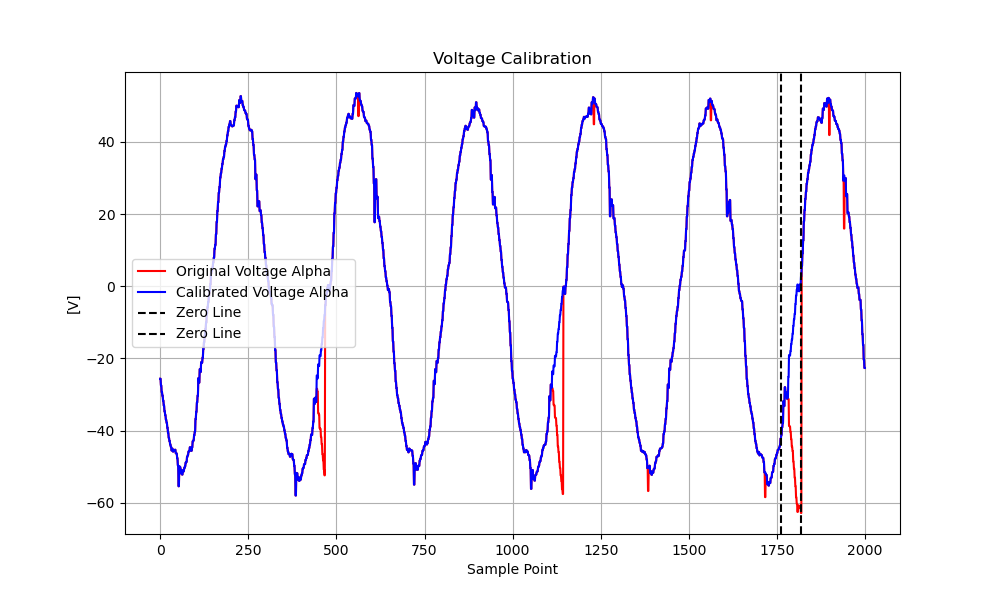

In [24]:



v_alpha = read_rul_data(rul2_files[24])["Voltage alpha"]
v_beta = read_rul_data(rul2_files[24])["Voltage beta"]

v_alpha= sampled_data["Voltage alpha"]
v_beta= sampled_data["Voltage beta"]

v_ab=(3*v_alpha-math.sqrt(3)*v_beta)/2
v_bc=math.sqrt(3)*(v_beta)

def voltage_calibrate(raw_voltage, threshold, speed=1):
   
    check_length=int (20000/(speed/3000*200)/4) # 取1/4 週期作為檢測窗長度
    calib_signal = np.copy(raw_voltage)
    
    # 從尾端往前掃描
    for i in range(len(raw_voltage) - 1, 0, -1):
        #檢查訊號差突變點
        if raw_voltage[i]- raw_voltage[i - 1] > threshold and  raw_voltage[i]*raw_voltage[i - 1]<0:
            closest_idx = None
            closest_val = float('inf') 
            for idx in range(max(i-check_length,0), i):
                if (abs(raw_voltage[idx]))<closest_val:
                    closest_val = abs(raw_voltage[idx])
                    closest_idx = idx
            # print(f"Calibrate from {max(i-check_length,0)} to {closest_idx}")
            calib_signal[closest_idx:i]= abs(raw_voltage[closest_idx:i])
            
    return calib_signal
def voltage_calibrate_stator(v_alpha, v_beta, threshold, speed=1 ):
    #轉換回 vsensing 線間電壓
    v_ab=(3*v_alpha-math.sqrt(3)*v_beta)/2
    v_bc=math.sqrt(3)*(v_beta)
    # 對 v_ab 和 v_bc 進行校準
    v_ab=voltage_calibrate(v_ab, threshold, speed)
    v_bc=voltage_calibrate(v_bc, threshold, speed)
    #轉換回 alpha beta 電壓
    v_alpha = (2*v_ab + v_bc)/3
    v_beta = v_bc/math.sqrt(3)
    return v_alpha, v_beta

speed=sampled_data["Speed"][0]
window_lenght=int (20000/(speed/3000*200)/4) # 取1/4 週期作為檢測窗長度
print(f"Window length: {window_lenght}")

voltage_alpha=voltage_calibrate(v_ab, 15, 1800)

voltage_alpha, voltage_beta = voltage_calibrate_stator(v_alpha, v_beta, 15, 1800)

# filtered_voltage,_=filter_top_n_frequencies(voltage_alpha, 5)
plt.figure(figsize=(10, 6))
plt.plot(v_alpha, linestyle='-', color='r', label='Original Voltage Alpha')
plt.plot(voltage_alpha, linestyle='-', color='b', label='Calibrated Voltage Alpha')
plt.axvline(x=1760, color='k', linestyle='--', label='Zero Line')
plt.axvline(x=1818, color='k', linestyle='--', label='Zero Line')
plt.xlabel("Sample Point")
plt.ylabel("[V]")
plt.title("Voltage Calibration")
plt.legend()
plt.grid()

In [5]:
print(rul2_files[idx1])

D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_1V\Speed_1800\Pressure_10psi\15kg_1V_1800rpm_1\RUL_Data_3_4.parquet
